# Learning task 1 - RobotArm

# Overall analysis 

In [85]:
import pandas as pd 
from distances import *
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

In [86]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

folder = "plot_l1"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == "P1M120"]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
initial_worldspace = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']" 
initial_distance = euclidean_v1(initial_worldspace, key_vector_l1)

In [87]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1967


### Cleaning the data

In [88]:
# remove rows where there is NaN value in the WorldSpace column
robotarm = robotarm.dropna(subset=['WorldSpace'])

print(f"Number of rows after filtering the NaN values: {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after filtering the NaN values: 1708
Number of rows removed: 259
Percentage of rows removed: 13.167259786476869%


In [89]:
# remove the rows where the WorldSpace contains "trial"
robotarm = robotarm[~robotarm['WorldSpace'].str.contains("trial")]

print(f"Number of rows after removing 'trial' (non-consistent worldspace): {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing 'trial' (non-consistent worldspace): 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


I have seen in a lot of cases that sometimes the number of elements do not match the goals number of elements, so there was an error that occured, but the last cell is still marked as "false". 

Let's correct this: if the world space does not have the same number of elements as the goals state, then there is an error. To do that, we will simply change the "false" into "true". 

In [90]:
import numpy as np 
from distances import *

def detect_error(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
    
    return initial_count_A != goal_count_A or initial_count_B != goal_count_B


In [91]:
for idx, row in robotarm.iterrows():
    if detect_error(row['WorldSpace'], key_vector_l1):
        robotarm.loc[idx, 'WorldSpace'] = row['WorldSpace'].replace("false", "missing_place") 
        #'missing_place' means that the code was run, but student forgot to place the object -> one missing block code

It may be the case that when data was collected, there was errors. 
One thing that I noticed is that in some cases, we have more elements than we should have, i.e. for the learning task 1, we should have a maximum of 2 As. If we have more, or also any B element, that means that the worldspace is not correct for the task, so the line should be removed in that case. 

In [92]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

def detect_bad_matrix(v):
    v_matrix = preprocess(v)
    
    nb_col = v_matrix.shape[1]
    nb_row = v_matrix.shape[0]
    
    return nb_col != 5 or nb_row != 6

In [93]:
robotarm['longer_worldspace'] = robotarm.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector_l1), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['longer_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['longer_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [94]:
robotarm['missing_worldspace'] = robotarm.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector_l1), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['missing_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['missing_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1708
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [95]:
print(f"Number of rows after filtering: {robotarm.shape[0]}")
print(f"Number of rows removed from filtering the initial dataset: {initial_length - robotarm.shape[0]}")
print(f"Percentage of rows removed from filtering the initial dataset: {100*(initial_length - robotarm.shape[0])/initial_length}%")

Number of rows after filtering: 1708
Number of rows removed from filtering the initial dataset: 259
Percentage of rows removed from filtering the initial dataset: 13.167259786476869%


Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [96]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [97]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Compute euclidean distance

In [98]:
robotarm['euclidean_distance'] = robotarm['WorldSpace'].apply(lambda x: euclidean_v1(x, key_vector_l1))
robotarm['euclidean_distance_no_penalty'] = robotarm['WorldSpace'].apply(lambda x: euclidean_v1(x, key_vector_l1, penalty=False))

### Add initial vector and distance for each student

In [99]:
data = robotarm[["Student ID", "WorldSpace", "index", "euclidean_distance", "euclidean_distance_no_penalty"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 
                             'index': 0, 'euclidean_distance': initial_distance, 'euclidean_distance_no_penalty': initial_distance})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_34868/904709205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


### Create column corresponding to percentage of activity completed

In [100]:
data['pct_activity'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [101]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 371


In [102]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

### Create column to indicate if the student made an error or not during the tentative

In [103]:
def is_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return matrix[-1][-1] != 'false' and matrix[-1][-1] != 'missing_place'

In [104]:
def type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0

In [105]:
data['error'] = data['WorldSpace'].apply(lambda x: is_error(x))

In [106]:
# transform the error column into a binary column
data['error'] = data['error'].apply(lambda x: 1 if x == True else 0)

In [107]:
def collect_type_errors(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    return matrix[-1][-1]

In [108]:
all_type_errors = []

for idx, row in data.iterrows():
    error = collect_type_errors(row['WorldSpace'])
    
    if error not in all_type_errors:
        all_type_errors.append(error)
        
all_type_errors

['false', 'move1', 'missing_place', 'place1', 'pickup1']

In [109]:
data['error_move1'] = data['WorldSpace'].apply(lambda x: type_error(x, 'move1'))
data['error_move2'] = data['WorldSpace'].apply(lambda x: type_error(x, 'move2'))
data['error_pickup1'] = data['WorldSpace'].apply(lambda x: type_error(x, 'pickup1'))
data['error_place1'] = data['WorldSpace'].apply(lambda x: type_error(x, 'place1'))

In [110]:
# look at how many have forgotten the 'place' at the end -> NOT AN ERROR 
data['missing_place'] = data['WorldSpace'].apply(lambda x: type_error(x, 'missing_place'))

data["nb_error"] = data.groupby('Student ID')['error'].transform('sum')
data["nb_missing_place"] = data.groupby('Student ID')['missing_place'].transform('sum')

data["nb_error_move1"] = data.groupby('Student ID')['error_move1'].transform('sum')
data["nb_error_move2"] = data.groupby('Student ID')['error_move2'].transform('sum')
data["nb_error_pickup1"] = data.groupby('Student ID')['error_pickup1'].transform('sum')
data["nb_error_place1"] = data.groupby('Student ID')['error_place1'].transform('sum')

### Add column of difference in the euclidean distance between previous row and successive row

In [111]:
data['delta'] = data.groupby('Student ID')['euclidean_distance'].diff()
data['delta_no_penalty'] = data.groupby('Student ID')['euclidean_distance_no_penalty'].diff()

#data = data.dropna(subset=['delta', 'delta_no_penalty'])
data[['delta', 'delta_no_penalty']] = data[['delta', 'delta_no_penalty']].fillna(0)

### Add column for percentage of error over number of total tentatives 


In [112]:
data['pct_error'] = data['nb_error'] / data['nb_tentative']

data['pct_error_move1'] = data['nb_error_move1'] / data['nb_tentative']
data['pct_error_move2'] = data['nb_error_move2'] / data['nb_tentative']
data['pct_error_pickup1'] = data['nb_error_pickup1'] / data['nb_tentative']
data['pct_error_place1'] = data['nb_error_place1'] / data['nb_tentative']

### Separate the successful and failing students

In [113]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  371
Number of students who succeeded:  273
Number of students who failed:  98


In [114]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_34868/1419184903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_34868/1419184903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fail['success'] = 0


In [115]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'euclidean_distance': 'mean', 'euclidean_distance_no_penalty': 'mean', 'nb_tentative': 'max', 'nb_error': 'max', 'nb_error_move1': 'max', 'nb_error_move2': 'max', 'nb_error_pickup1': 'max', 'nb_error_place1': 'max', 'pct_error': 'max', 'pct_error_move1': 'max', 'pct_error_move2': 'max', 'pct_error_pickup1': 'max', 'pct_error_place1': 'max'})
data_grouped_per_student.columns = ['mean_euclidean_distance', 'mean_euclidean_distance_no_penalty', 'nb_tentative', 'nb_error', 'nb_error_move1', 'nb_error_move2', 'nb_error_pickup1', 'nb_error_place1', 'pct_error', 'pct_error_move1', 'pct_error_move2', 'pct_error_pickup1', 'pct_error_place1']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_34868/166176106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_34868/166176106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_fail['success'] = 0


In [116]:
# sum of the column error over the length of the dataset
pct_error_success = data_success['error'].sum() / len(data_success)
pct_error_fail = data_fail['error'].sum() / len(data_fail)
pct_error_tot = data['error'].sum() / len(data)

print(f"Percentage of error for all the tentatives in successful students dataset: {pct_error_success:.2f}")
print(f"Percentage of error for all the tentatives in failing students dataset: {pct_error_fail:.2f}")
print(f"Percentage of error for all the tentatives in the whole dataset: {pct_error_tot:.2f}")

Percentage of error for all the tentatives in successful students dataset: 0.35
Percentage of error for all the tentatives in failing students dataset: 0.37
Percentage of error for all the tentatives in the whole dataset: 0.35


# Analysis 

In [117]:
data[['index', 'nb_tentative', 'euclidean_distance', 'euclidean_distance_no_penalty', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,euclidean_distance_no_penalty,delta,pct_activity
count,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000
mean,3.493987,6.987975,0.444659,0.406516,-0.088089,0.500000
std,3.608865,4.833448,0.244836,0.233522,0.231819,0.353211
min,0.000000,1.000000,0.000000,0.000000,-0.724695,0.000000
25%,1.000000,4.000000,0.321960,0.321960,-0.156174,0.200000
50%,2.000000,6.000000,0.468521,0.468521,0.000000,0.500000
75%,5.000000,9.000000,0.624695,0.624695,0.000000,0.800000
max,23.000000,23.000000,0.724695,0.624695,0.724695,1.000000


In [118]:
data_success[['index', 'nb_tentative', 'euclidean_distance', 'euclidean_distance_no_penalty', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,euclidean_distance_no_penalty,delta,pct_activity
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,3.338710,6.677419,0.413738,0.376255,-0.108691,0.500000
std,3.349762,4.378089,0.265075,0.251134,0.253130,0.350846
min,0.000000,1.000000,0.000000,0.000000,-0.724695,0.000000
25%,1.000000,4.000000,0.100000,0.000000,-0.156174,0.200000
50%,2.000000,6.000000,0.468521,0.468521,0.000000,0.500000
75%,5.000000,9.000000,0.624695,0.624695,0.000000,0.800000
max,22.000000,22.000000,0.724695,0.624695,0.724695,1.000000


In [119]:
data_grouped_per_student_success.describe()

,mean_euclidean_distance,mean_euclidean_distance_no_penalty,nb_tentative,nb_error,nb_error_move1,nb_error_move2,nb_error_pickup1,nb_error_place1,pct_error,pct_error_move1,pct_error_move2,pct_error_pickup1,pct_error_place1,success
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.0,273.000000,273.000000,273.000000,273.000000,273.0,273.000000,273.000000,273.0
mean,0.393815,0.365272,4.677656,1.981685,0.831502,0.0,0.406593,0.743590,0.317159,0.148139,0.0,0.065077,0.103943,1.0
std,0.084703,0.074066,3.375754,2.548723,1.163554,0.0,0.890861,1.509835,0.252994,0.177688,0.0,0.129688,0.161674,0.0
min,0.181174,0.156174,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,0.322856,0.312348,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,0.387427,0.364405,4.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,1.0
75%,0.454478,0.416463,6.000000,3.000000,1.000000,0.0,1.000000,1.000000,0.500000,0.285714,0.0,0.062500,0.200000,1.0
max,0.604490,0.546608,22.000000,19.000000,8.000000,0.0,6.000000,12.000000,0.904762,0.750000,0.0,0.666667,0.714286,1.0


In [120]:
data_fail[['index', 'nb_tentative', 'euclidean_distance', 'euclidean_distance_no_penalty', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,euclidean_distance_no_penalty,delta,pct_activity
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,3.948960,7.897921,0.535258,0.495183,-0.027723,0.500000
std,4.249693,5.882126,0.136940,0.137946,0.136478,0.360388
min,0.000000,1.000000,0.100000,0.000000,-0.624695,0.000000
25%,1.000000,3.000000,0.468521,0.468521,-0.143502,0.166667
50%,3.000000,7.000000,0.568521,0.468521,0.000000,0.500000
75%,6.000000,12.000000,0.624695,0.624695,0.000000,0.833333
max,23.000000,23.000000,0.724695,0.624695,0.468521,1.000000


In [121]:
data_grouped_per_student_fail.describe()

,mean_euclidean_distance,mean_euclidean_distance_no_penalty,nb_tentative,nb_error,nb_error_move1,nb_error_move2,nb_error_pickup1,nb_error_place1,pct_error,pct_error_move1,pct_error_move2,pct_error_pickup1,pct_error_place1,success
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.0
mean,0.540120,0.512268,4.397959,2.000000,0.612245,0.0,0.438776,0.948980,0.334063,0.088476,0.0,0.073736,0.171851,0.0
std,0.068226,0.070923,4.368915,3.046038,1.240491,0.0,1.084724,1.562264,0.371283,0.176758,0.0,0.185319,0.262135,0.0
min,0.309878,0.249878,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,0.520579,0.497053,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,0.546608,0.531128,3.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.218750,0.000000,0.0,0.000000,0.000000,0.0
75%,0.572637,0.546608,6.000000,3.000000,1.000000,0.0,0.000000,1.000000,0.650000,0.094231,0.0,0.000000,0.250000,0.0
max,0.699695,0.624695,23.000000,16.000000,6.000000,0.0,7.000000,8.000000,1.000000,0.750000,0.0,1.000000,1.000000,0.0


In [122]:
data_grouped_per_student.describe()

,mean_euclidean_distance,mean_euclidean_distance_no_penalty,nb_tentative,nb_error,nb_error_move1,nb_error_move2,nb_error_pickup1,nb_error_place1,pct_error,pct_error_move1,pct_error_move2,pct_error_pickup1,pct_error_place1,success
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.0,371.000000,371.000000,371.000000,371.000000,371.0,371.000000,371.000000,371.000000
mean,0.432462,0.404101,4.603774,1.986523,0.773585,0.0,0.415094,0.797844,0.321624,0.132379,0.0,0.067364,0.121881,0.735849
std,0.103278,0.097790,3.660141,2.684758,1.186616,0.0,0.944508,1.524430,0.288528,0.179151,0.0,0.146227,0.195265,0.441475
min,0.181174,0.156174,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.355844,0.332273,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.432145,0.394707,4.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,1.000000
75%,0.518521,0.479010,6.000000,3.000000,1.000000,0.0,0.000000,1.000000,0.500000,0.250000,0.0,0.000000,0.222222,1.000000
max,0.699695,0.624695,23.000000,19.000000,8.000000,0.0,7.000000,12.000000,1.000000,0.750000,0.0,1.000000,1.000000,1.000000


### Euclidean distance

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

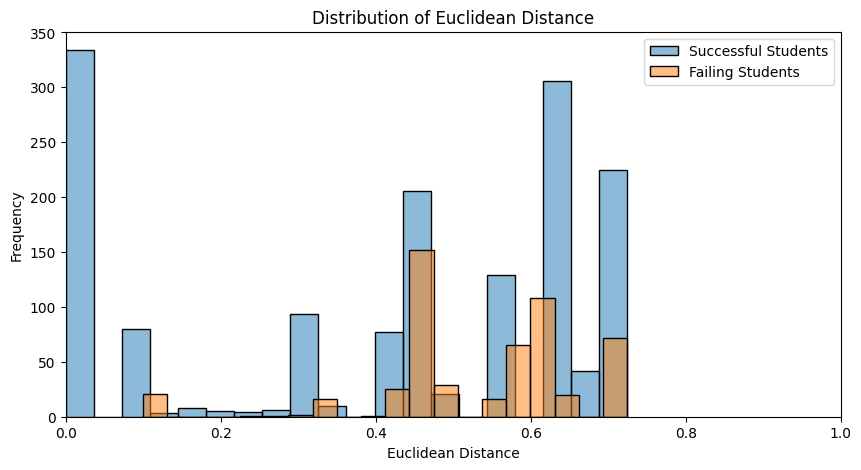

In [123]:
plt.figure(figsize=(10, 5))
sns.histplot(data_success['euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_fail['euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

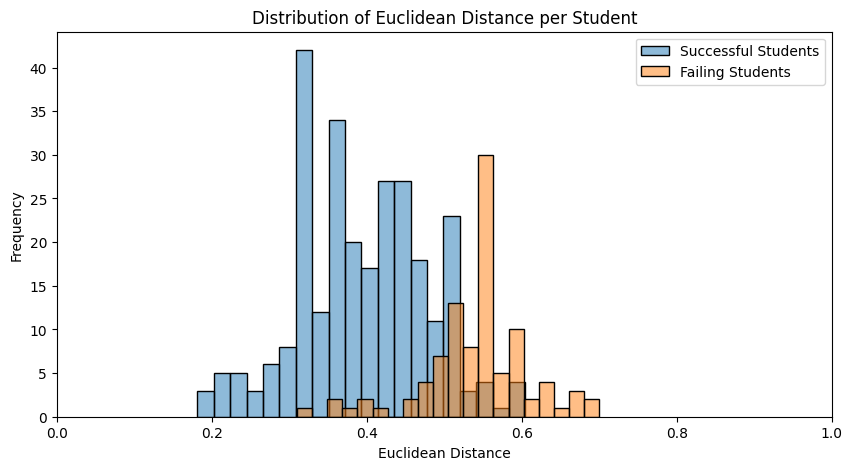

In [124]:
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['mean_euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['mean_euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance per Student')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_per_student.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

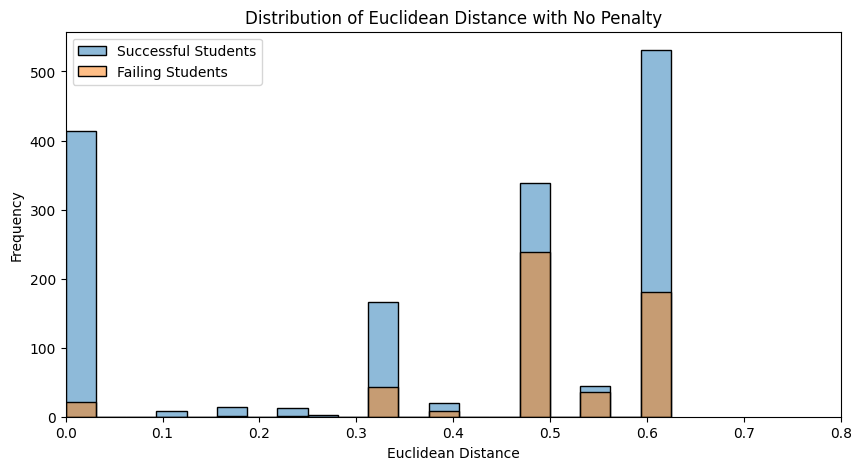

In [125]:
# Create histograms for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.histplot(data_success['euclidean_distance_no_penalty'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_fail['euclidean_distance_no_penalty'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 0.8)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance with No Penalty')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_no_penalty.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

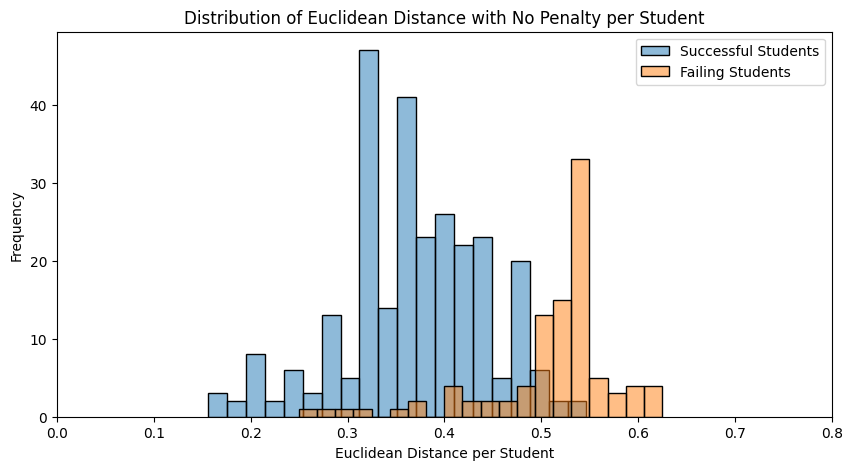

In [126]:
# Create histograms for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['mean_euclidean_distance_no_penalty'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['mean_euclidean_distance_no_penalty'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 0.8)
plt.xlabel('Euclidean Distance per Student')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance with No Penalty per Student')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_no_penalty_per_student.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


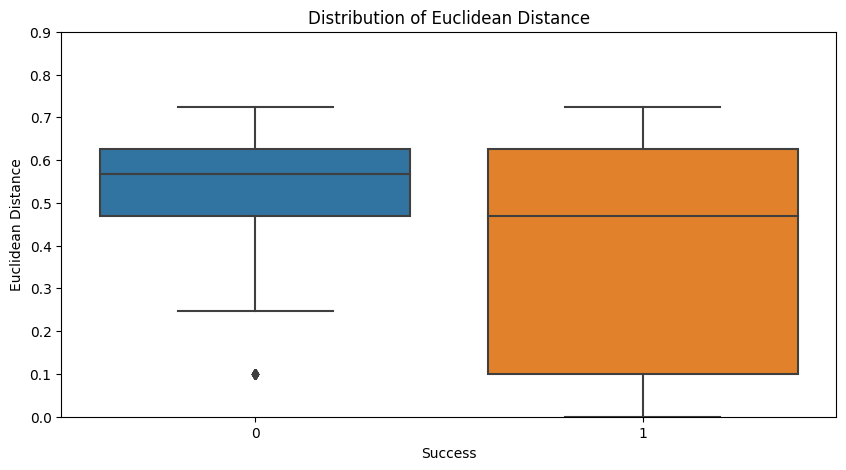

In [127]:
# Create box plots for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='euclidean_distance', data=data)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance')
plt.ylim(0, 0.9)
plt.savefig(f"{folder}/boxplot_euclidean_distance.png")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


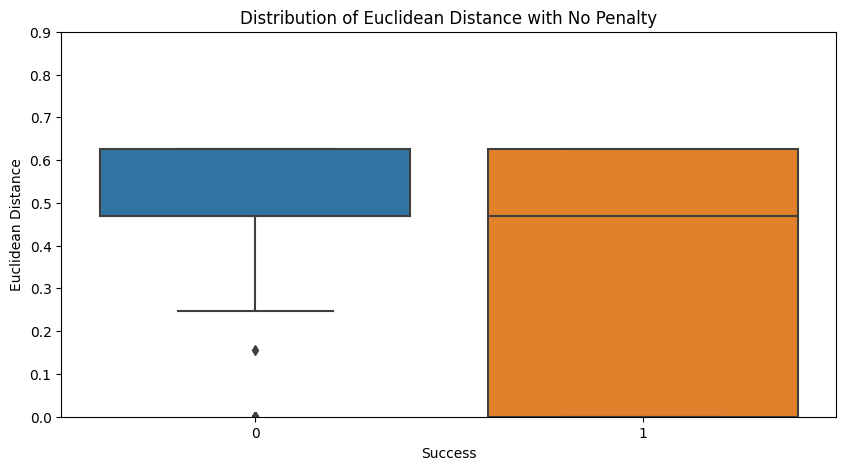

In [128]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='euclidean_distance_no_penalty', data=data)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance with No Penalty')
plt.ylim(0, 0.9)
plt.savefig(f"{folder}/boxplot_euclidean_distance_no_penalty.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


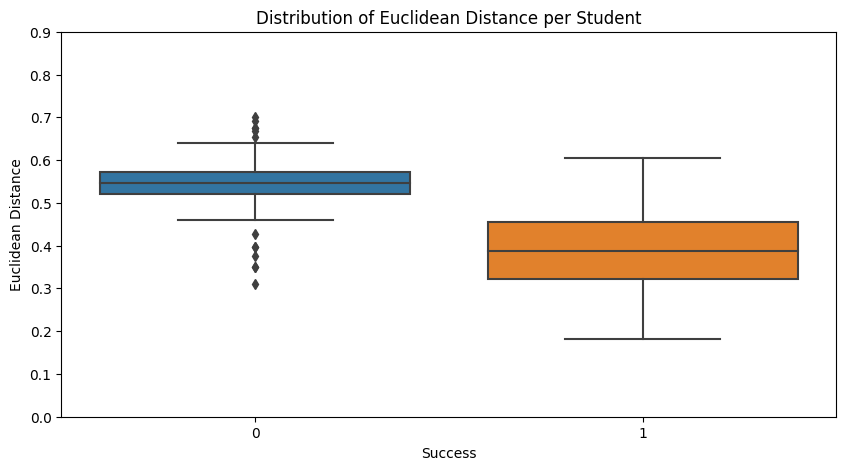

In [129]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='mean_euclidean_distance', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance per Student')
plt.ylim(0, 0.9)
plt.savefig(f"{folder}/boxplot_euclidean_distance_per_student.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


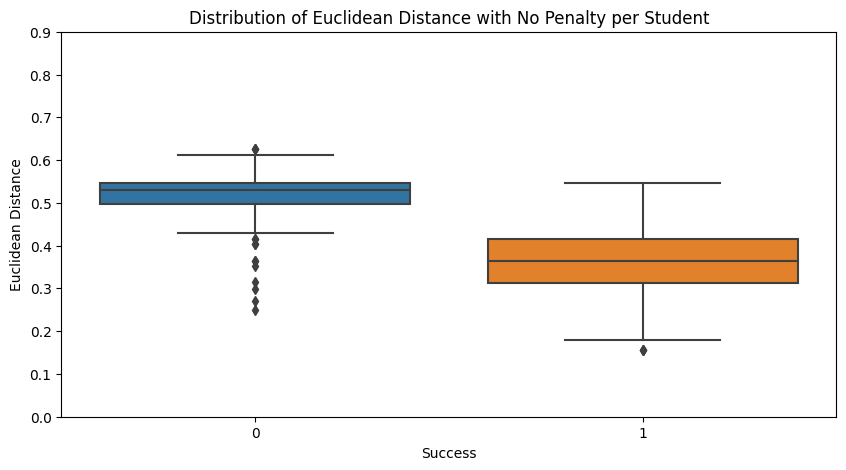

In [130]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='mean_euclidean_distance_no_penalty', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance with No Penalty per Student')
plt.ylim(0, 0.9)
plt.savefig(f"{folder}/boxplot_euclidean_distance_no_penalty_per_student.png")

plt.show()

In [131]:
# Assuming 'euclidean_distance_successful' and 'euclidean_distance_failing' are arrays of Euclidean distances
statistic, p_value = mannwhitneyu(data_success['euclidean_distance'], data_fail['euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of Euclidean distance (p >= 0.05)")
    
    
statistic, p_value = mannwhitneyu(data_success['euclidean_distance_no_penalty'], data_fail['euclidean_distance_no_penalty'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of Euclidean distance (p >= 0.05)")



There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)
There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)


### Number of tentatives/runs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

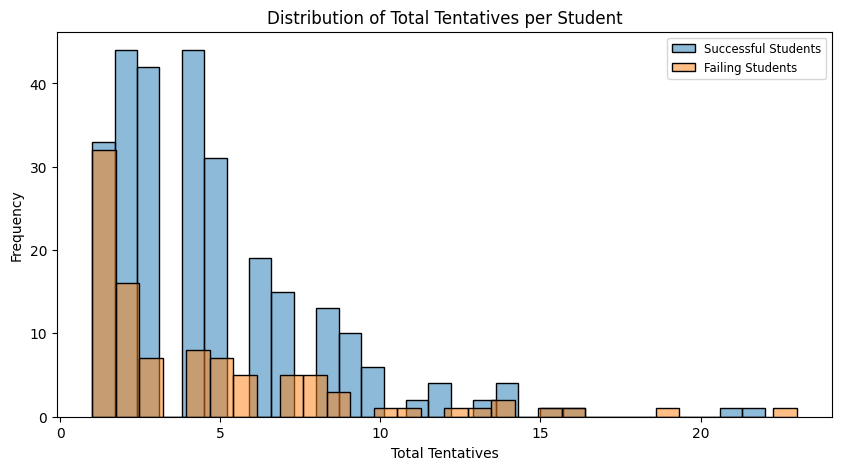

In [132]:
# Create histograms for the number of tentatives
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['nb_tentative'], bins=30, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['nb_tentative'], bins=30, label='Failing Students', alpha=0.5)
plt.xlabel('Total Tentatives')
plt.ylabel('Frequency')
plt.title('Distribution of Total Tentatives per Student')
plt.legend(fontsize='small')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


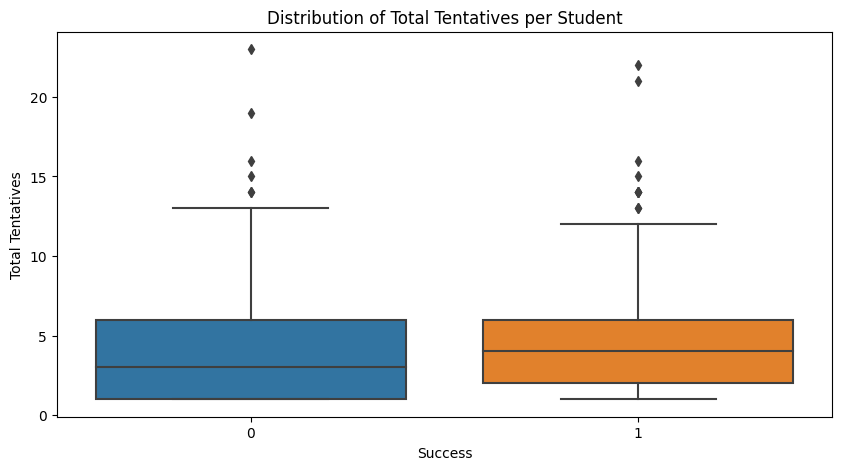

In [133]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')
plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student.png")

plt.show()

In [134]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)


### Observe the number of errors per students 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

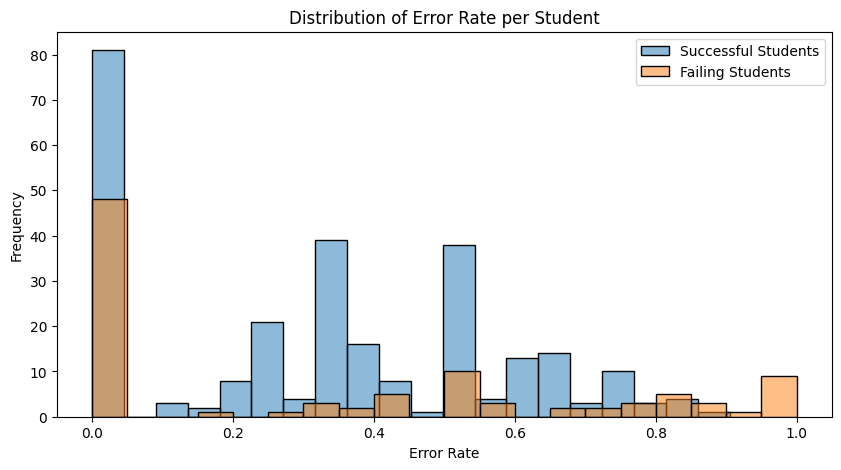

In [135]:
# plot distribution of percentage of error
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()
plt.savefig(f"{folder}/error_rate_per_student.png")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


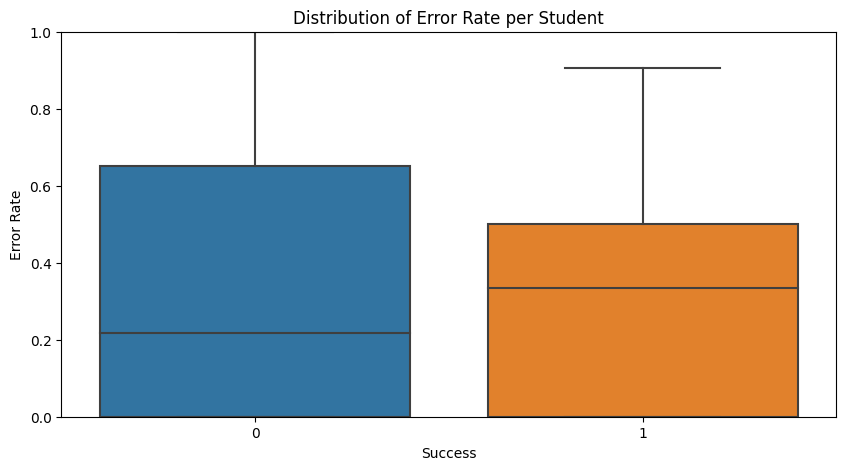

In [136]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='pct_error', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.ylim(0, 1)
plt.title('Distribution of Error Rate per Student')

plt.savefig(f"{folder}/boxplot_error_rate_per_student.png")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


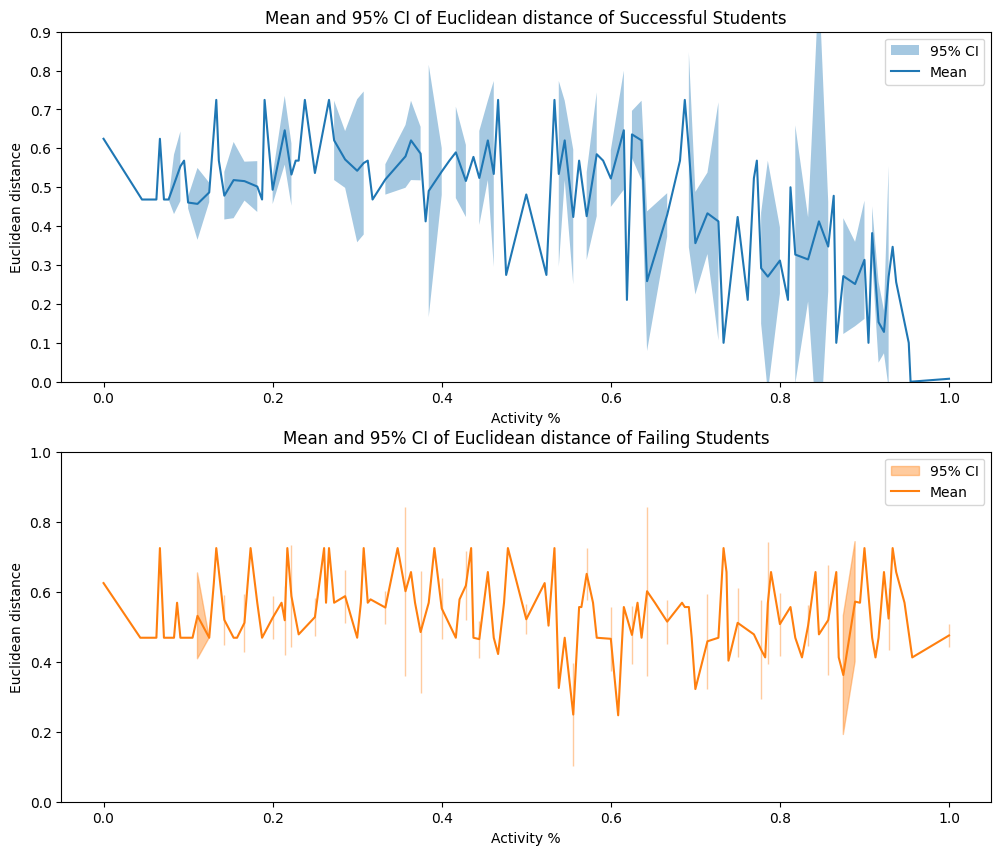

In [137]:
# plot one figure
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

grouped_success = data_success.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_success = grouped_success["euclidean_distance"].mean()
ci_values_bars_success = grouped_success["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[0].fill_between(mean_values_bars_success.index, mean_values_bars_success - ci_values_bars_success, mean_values_bars_success + ci_values_bars_success, alpha=0.4, label="95% CI")

ax[0].plot(mean_values_bars_success.index, mean_values_bars_success, linestyle='-', label="Mean")
ax[0].set_ylim(0, 0.9)
ax[0].set_xlabel("Activity %")
ax[0].set_ylabel("Euclidean distance")
ax[0].set_title("Mean and 95% CI of Euclidean distance of Successful Students")
ax[0].legend()

grouped_fail = data_fail.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_fail = grouped_fail["euclidean_distance"].mean()
ci_values_bars_fail = grouped_fail["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[1].fill_between(mean_values_bars_fail.index, mean_values_bars_fail - ci_values_bars_fail, mean_values_bars_fail + ci_values_bars_fail, alpha=0.4, color= '#ff7f0e', label="95% CI")

ax[1].plot(mean_values_bars_fail.index, mean_values_bars_fail, linestyle='-', color= '#ff7f0e', label="Mean")
ax[1].set_ylim(0, 0.9)
ax[1].set_xlabel("Activity %")
ax[1].set_ylabel("Euclidean distance")
ax[1].set_title("Mean and 95% CI of Euclidean distance of Failing Students")
ax[1].legend()
plt.ylim(0, 1)
plt.show()

In [138]:
data_success_filtered = data_success[data_success['nb_tentative'] <= 10]
data_fail_filtered = data_fail[data_fail['nb_tentative'] <= 10]

nb_student_success_filtered = len(data_success_filtered['Student ID'].unique())
nb_student_fail_filtered = len(data_fail_filtered['Student ID'].unique())

print(f"Number of successful students after filtering: {nb_student_success_filtered}")
print(f"Number of failing students after filtering: {nb_student_fail_filtered}")

print(f"Number of rows in successful students dataset after filtering: {data_success_filtered.shape[0]}")
print(f"Number of rows in failing students dataset after filtering: {data_fail_filtered.shape[0]}")

Number of successful students after filtering: 257
Number of failing students after filtering: 89
Number of rows in successful students dataset after filtering: 1308
Number of rows in failing students dataset after filtering: 383


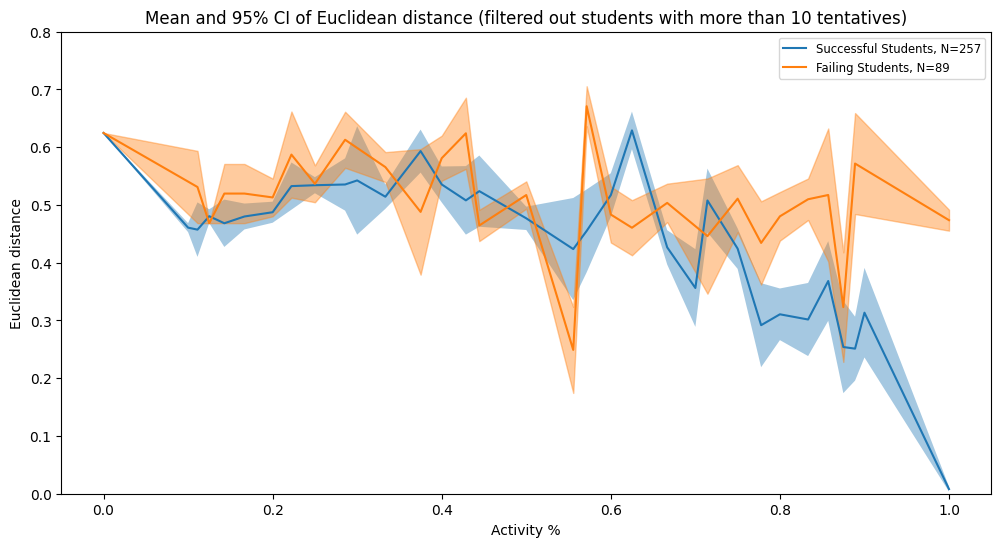

In [139]:
grouped_success = data_success_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_success = grouped_success.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_success['ci_value'] = grouped_success["euclidean_distance_sem"] * 1.96

grouped_fail = data_fail_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_fail = grouped_fail.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_fail['ci_value'] = grouped_fail["euclidean_distance_sem"] * 1.96


# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', label=f"Successful Students, N={nb_student_success_filtered}")

ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.4)
ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', label=f"Failing Students, N={nb_student_fail_filtered}")

# Set labels and title
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distance (filtered out students with more than 10 tentatives)")
ax.legend(fontsize='small')
plt.ylim(0, 0.8)

plt.savefig(f'{folder}/euclidean_dist_act_pct.png')
plt.show()

In [140]:
data_success_per_nb_tentative = data_success.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                          'pct_error_move1': ['mean', 'sem'], 'pct_error_move2': ['mean', 'sem'], 
                                                                          'pct_error_pickup1': ['mean', 'sem'], 'pct_error_place1': ['mean', 'sem']})
data_success_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

data_fail_per_nb_tentative = data_fail.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                    'pct_error_move1': ['mean', 'sem'], 'pct_error_move2': ['mean', 'sem'], 
                                                                    'pct_error_pickup1': ['mean', 'sem'], 'pct_error_place1': ['mean', 'sem']})
data_fail_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

# fill the NaN values with 0
data_success_per_nb_tentative = data_success_per_nb_tentative.fillna(0)
data_fail_per_nb_tentative = data_fail_per_nb_tentative.fillna(0)

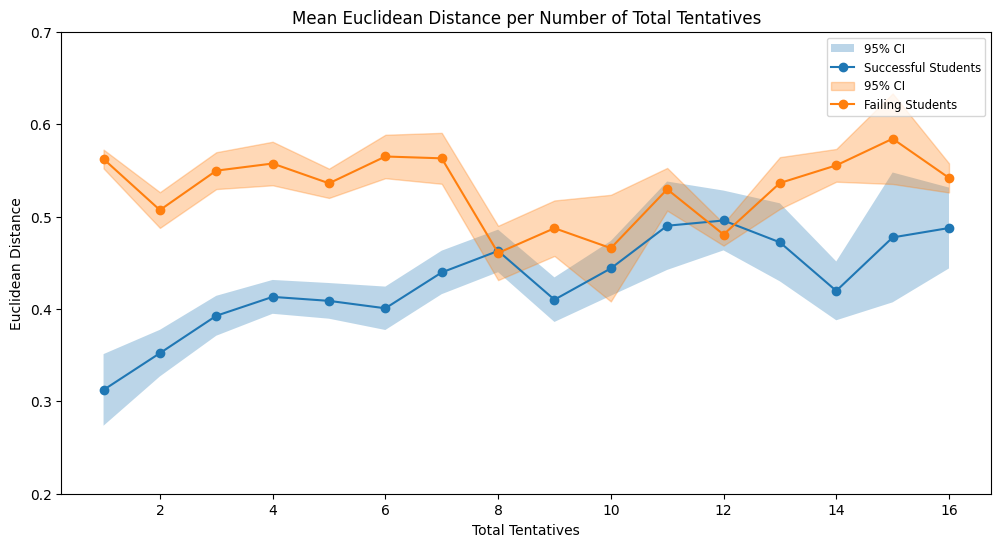

In [141]:
nb_tentative_success = data_success_per_nb_tentative.index.to_list()
nb_tentative_fail = data_fail_per_nb_tentative.index.to_list()

nb_tentative_index = set(nb_tentative_success).intersection(set(nb_tentative_fail))

data_success_per_nb_tentative = data_success_per_nb_tentative[data_success_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()
data_fail_per_nb_tentative = data_fail_per_nb_tentative[data_fail_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()

# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'] - data_success_per_nb_tentative['euclidean_distance_sem'], 
                data_success_per_nb_tentative["euclidean_distance_mean"] + data_success_per_nb_tentative['euclidean_distance_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'] - data_fail_per_nb_tentative['euclidean_distance_sem'], 
                data_fail_per_nb_tentative["euclidean_distance_mean"] + data_fail_per_nb_tentative['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Mean Euclidean Distance per Number of Total Tentatives')
ax.legend(fontsize='small')
plt.ylim(0.2, 0.7)

plt.savefig(f"{folder}/mean_euclidean_distance_per_nb_tentative.png")

plt.show()

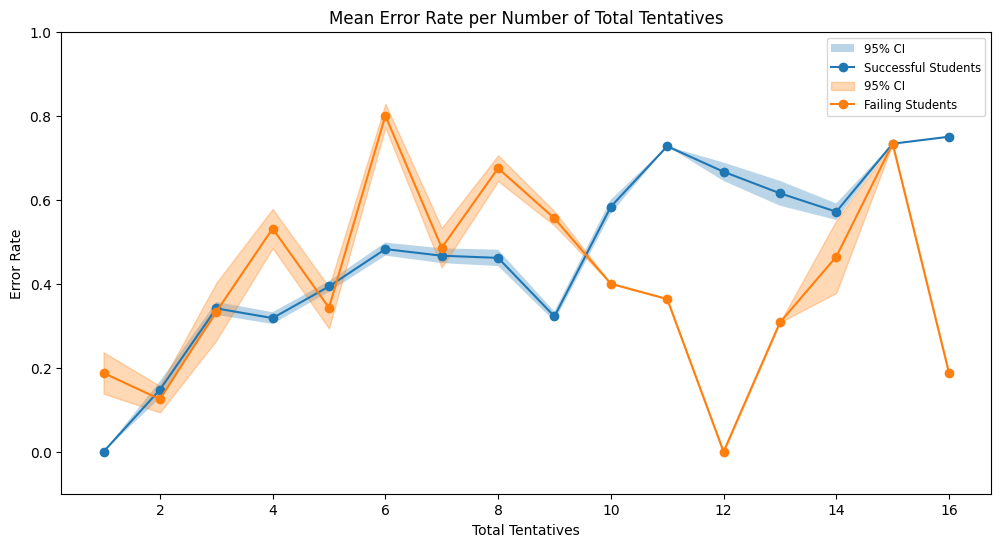

In [142]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'] - data_success_per_nb_tentative['pct_error_sem'], 
                data_success_per_nb_tentative["pct_error_mean"] + data_success_per_nb_tentative['pct_error_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'] - data_fail_per_nb_tentative['pct_error_sem'], 
                data_fail_per_nb_tentative["pct_error_mean"] + data_fail_per_nb_tentative['pct_error_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Error Rate')
ax.set_title('Mean Error Rate per Number of Total Tentatives')
ax.legend(fontsize='small')
plt.ylim(-0.1, 1)

plt.savefig(f"{folder}/error_rate_per_nb_tentatives.png")
plt.show()

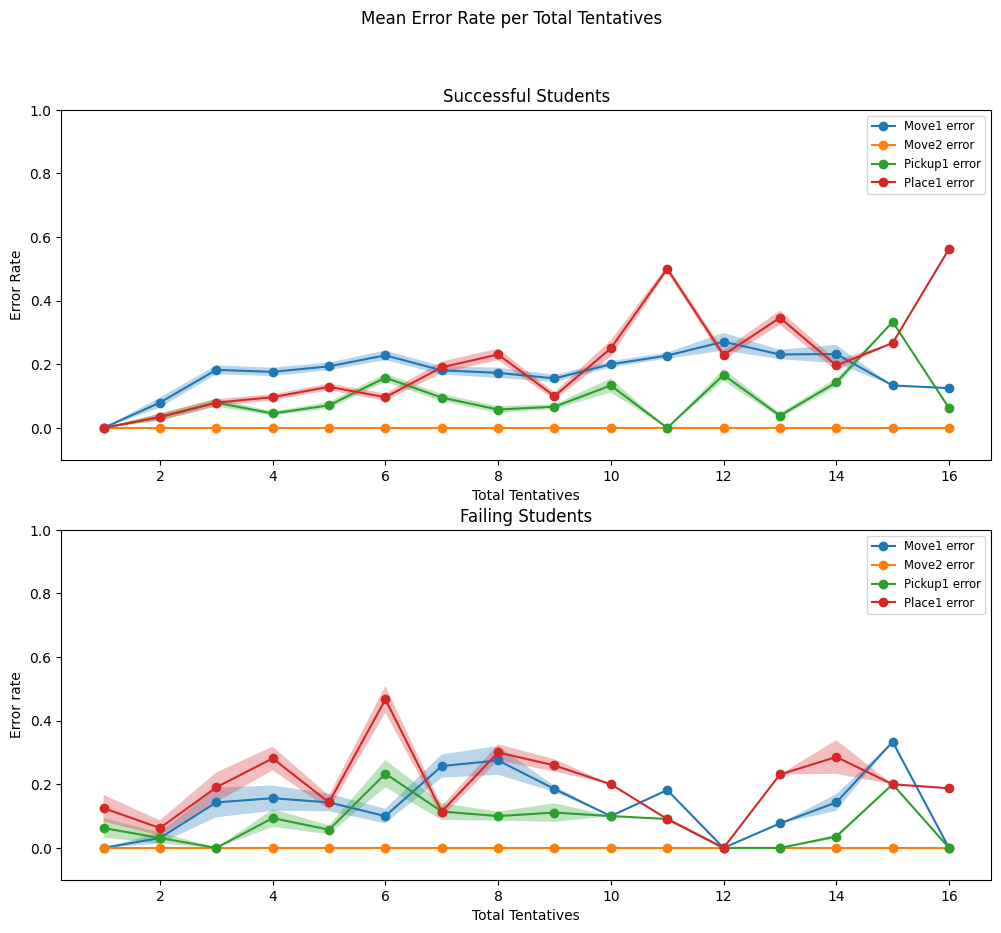

In [143]:
# plot the pct_error_move1, pct_error_move2, pct_error_pickup1, pct_error_pickup2 for Successful Students and Failing Students
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot change in Euclidean distance for successful students
ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move1_mean'] - data_success_per_nb_tentative['pct_move1_sem'], 
                data_success_per_nb_tentative["pct_move1_mean"] + data_success_per_nb_tentative['pct_move1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move1_mean'], linestyle='-', marker='o', label='Move1 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move2_mean'] - data_success_per_nb_tentative['pct_move2_sem'], 
                data_success_per_nb_tentative["pct_move2_mean"] + data_success_per_nb_tentative['pct_move2_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move2_mean'], linestyle='-', marker='o', label='Move2 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_pickup1_mean'] - data_success_per_nb_tentative['pct_pickup1_sem'], 
                data_success_per_nb_tentative["pct_pickup1_mean"] + data_success_per_nb_tentative['pct_pickup1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_pickup1_mean'], linestyle='-', marker='o', label='Pickup1 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_place1_mean'] - data_success_per_nb_tentative['pct_place1_sem'], 
                data_success_per_nb_tentative["pct_place1_mean"] + data_success_per_nb_tentative['pct_place1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_place1_mean'], linestyle='-', marker='o', label='Place1 error')
ax[0].set_ylim(-0.1, 1)
ax[0].set_xlabel('Total Tentatives')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Successful Students')
ax[0].legend(fontsize='small')

# Plot change in Euclidean distance for failing students
ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move1_mean'] - data_fail_per_nb_tentative['pct_move1_sem'], 
                data_fail_per_nb_tentative["pct_move1_mean"] + data_fail_per_nb_tentative['pct_move1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move1_mean'], linestyle='-', marker='o', label='Move1 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move2_mean'] - data_fail_per_nb_tentative['pct_move2_sem'], 
                data_fail_per_nb_tentative["pct_move2_mean"] + data_fail_per_nb_tentative['pct_move2_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move2_mean'], linestyle='-', marker='o', label='Move2 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_pickup1_mean'] - data_fail_per_nb_tentative['pct_pickup1_sem'],
                data_fail_per_nb_tentative["pct_pickup1_mean"] + data_fail_per_nb_tentative['pct_pickup1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_pickup1_mean'], linestyle='-', marker='o', label='Pickup1 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_place1_mean'] - data_fail_per_nb_tentative['pct_place1_sem'],
                data_fail_per_nb_tentative["pct_place1_mean"] + data_fail_per_nb_tentative['pct_place1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_place1_mean'], linestyle='-', marker='o', label='Place1 error')
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel('Total Tentatives')
ax[1].set_ylabel('Error rate')
ax[1].set_title('Failing Students')
ax[1].legend(fontsize='small')

plt.ylim(-0.1, 1)
plt.suptitle("Mean Error Rate per Total Tentatives")
plt.savefig(f"{folder}/type_error_rate_per_tentative.png")
plt.show()

* Move1 error more frequently 
* Pickup1 error more frequently, especially for Failing students

### Analysis of behaviors by grouping students by the number of tentatives

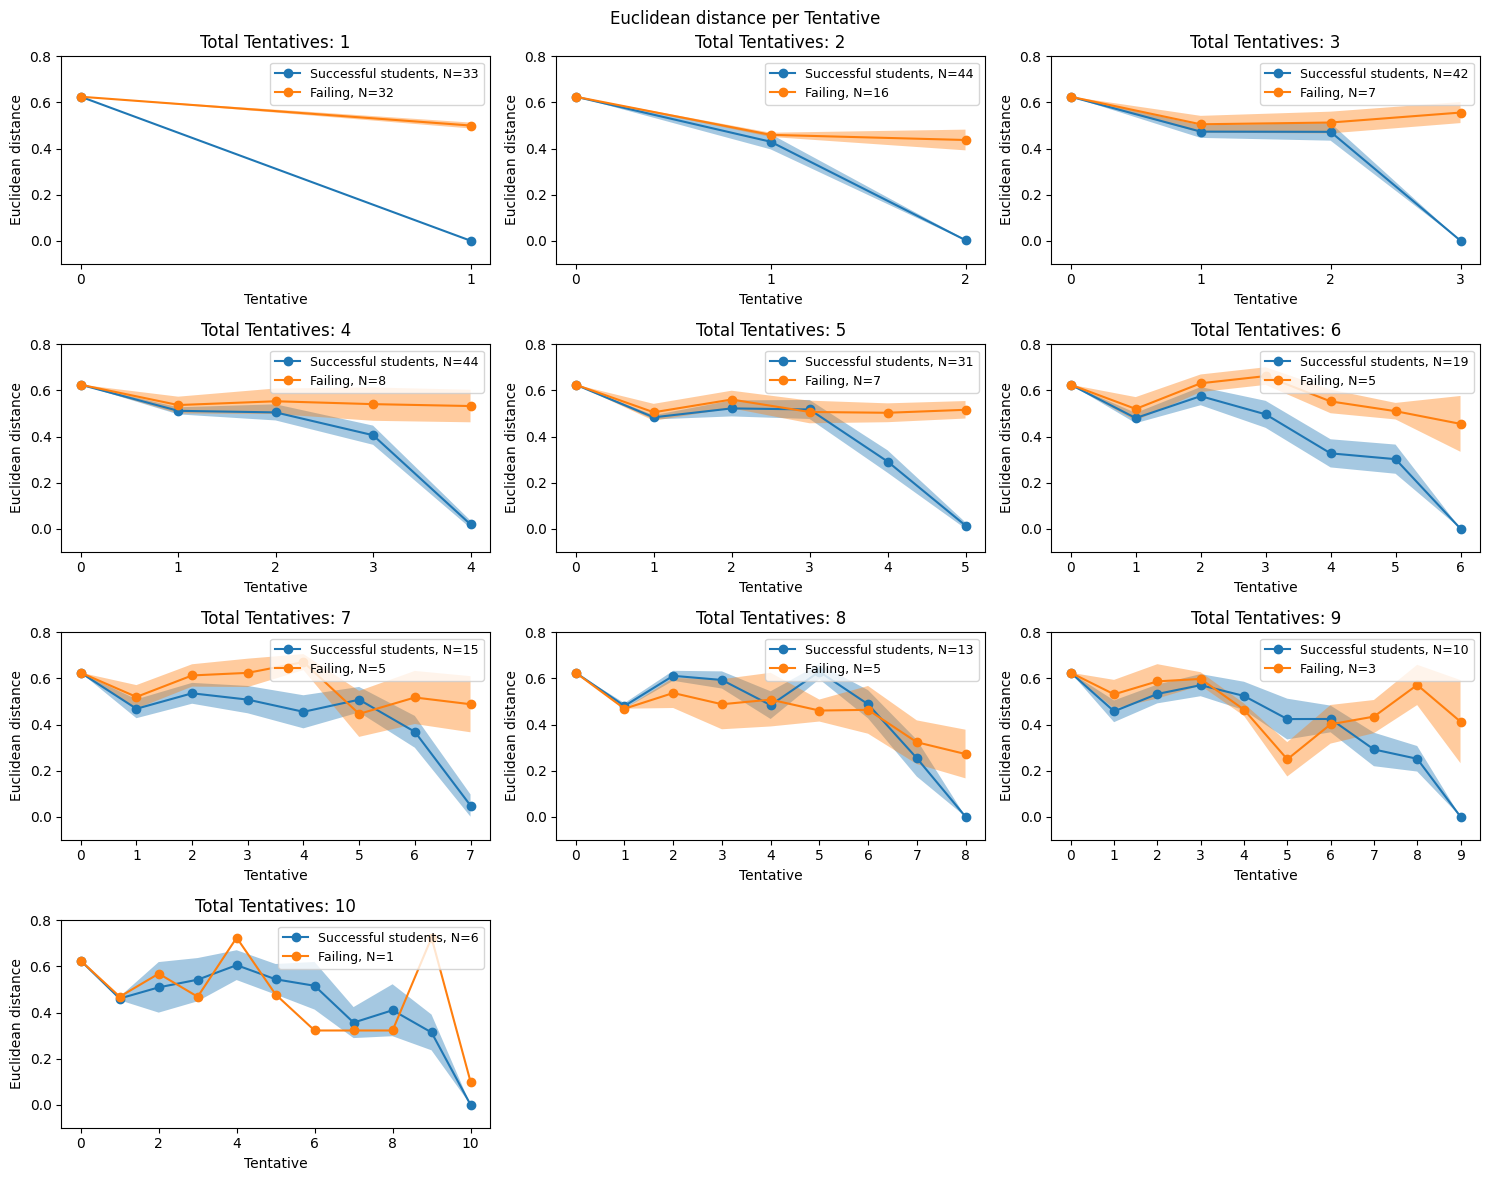

In [163]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['euclidean_distance_sem'].fillna(0, inplace=True)

        grouped_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['euclidean_distance_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Successful students, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        ax.set_ylim(-0.1, 0.8)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.legend(loc='upper right', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')


plt.suptitle("Euclidean distance per Tentative")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_per_tentative_multi.png")
plt.show()

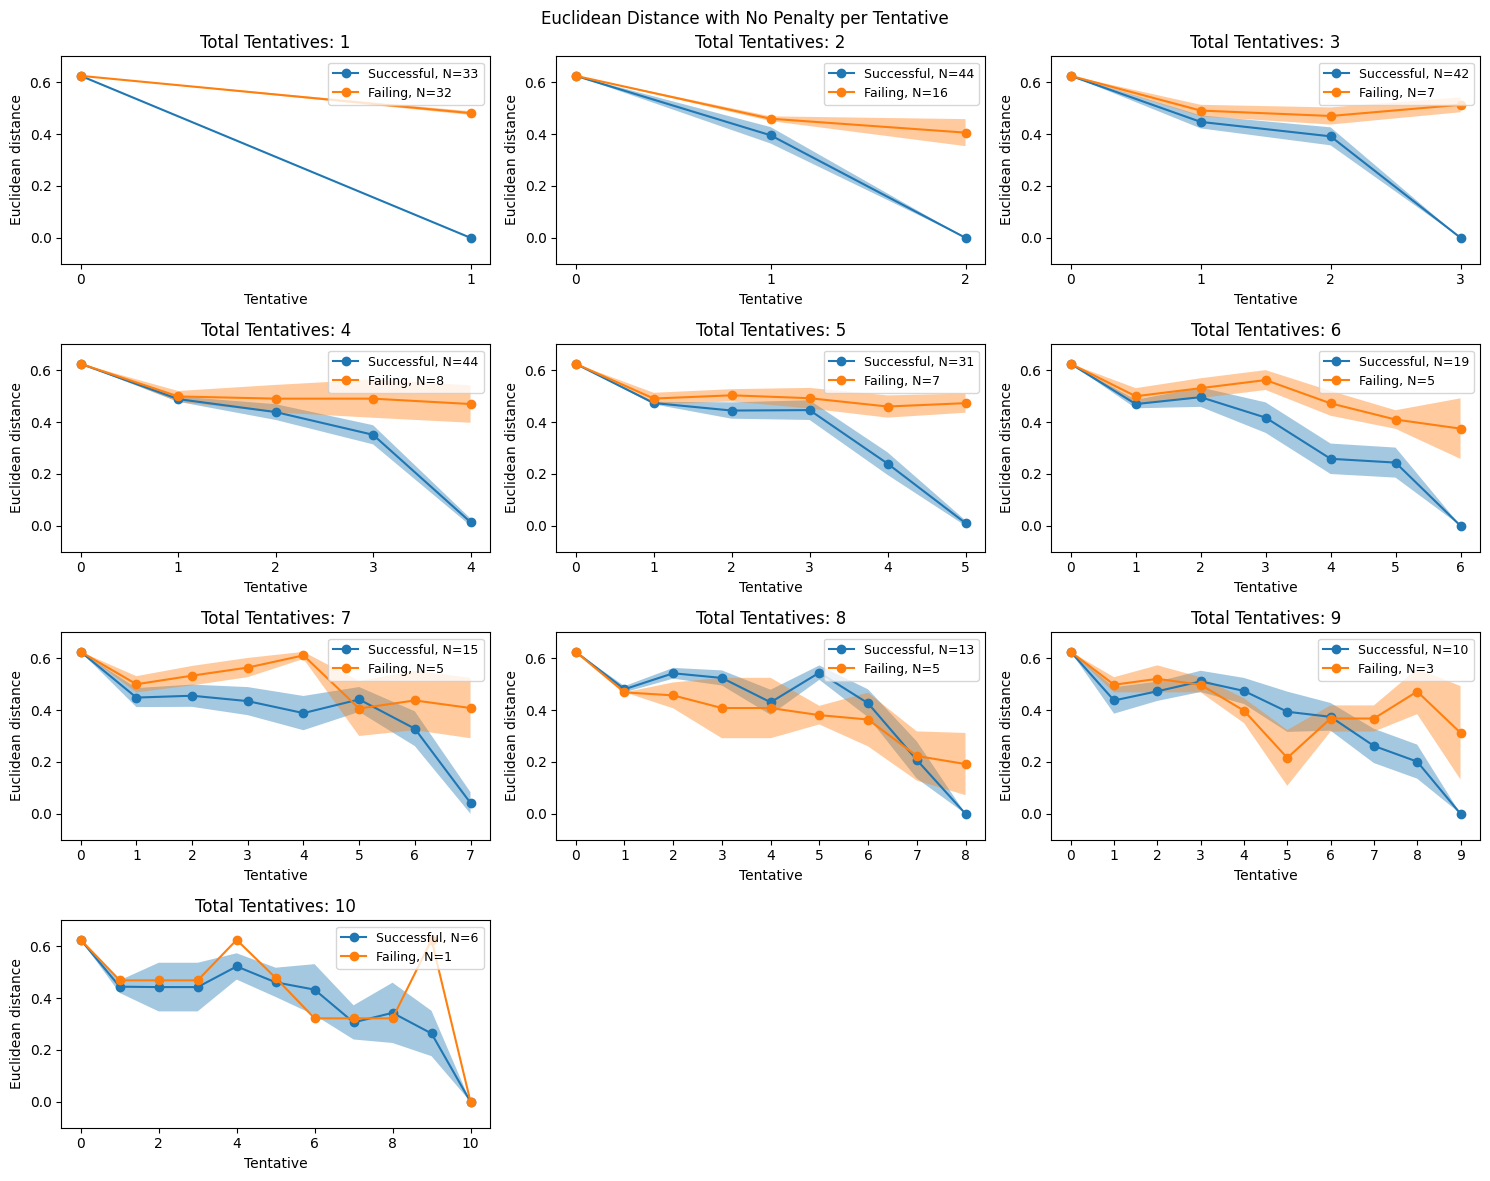

In [145]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance_no_penalty": ["mean", "sem", "count"]})
        grouped_success.columns = ["euclidean_distance_no_penalty_mean", "euclidean_distance_no_penalty_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['euclidean_distance_no_penalty_sem'].fillna(0, inplace=True)

        grouped_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance_no_penalty": ["mean", "sem", "count"]})
        grouped_fail.columns = ["euclidean_distance_no_penalty_mean", "euclidean_distance_no_penalty_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['euclidean_distance_no_penalty_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_no_penalty_mean'] - grouped_success['euclidean_distance_no_penalty_sem'], grouped_success["euclidean_distance_no_penalty_mean"] + grouped_success['euclidean_distance_no_penalty_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['euclidean_distance_no_penalty_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_no_penalty_mean'] - grouped_fail['euclidean_distance_no_penalty_sem'], grouped_fail["euclidean_distance_no_penalty_mean"] + grouped_fail['euclidean_distance_no_penalty_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_no_penalty_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        
        ax.set_ylim(-0.1, 0.7)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.legend(loc='upper right', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        # Add information about the number of students
    else:
        ax.axis('off')


plt.suptitle("Euclidean Distance with No Penalty per Tentative")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_no_penalty_multi.png")
plt.show()

* Redo same plot but for differences between successive runs 
* Evaluate the variations between successive runs 
* Observe some individual students 
* Redo same for L2 and L3

# Analysis of the difference between the successive runs

In [146]:
data_success_deltas = data_success[['Student ID', 'nb_tentative', 'index', 'delta', 'delta_no_penalty', 'error', 'pct_activity']]
data_failing_deltas = data_fail[['Student ID', 'nb_tentative', 'index', 'delta', 'delta_no_penalty', 'error', 'pct_activity']]

# group by Student ID and sort by index
data_success_deltas = data_success_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)
data_failing_deltas = data_failing_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

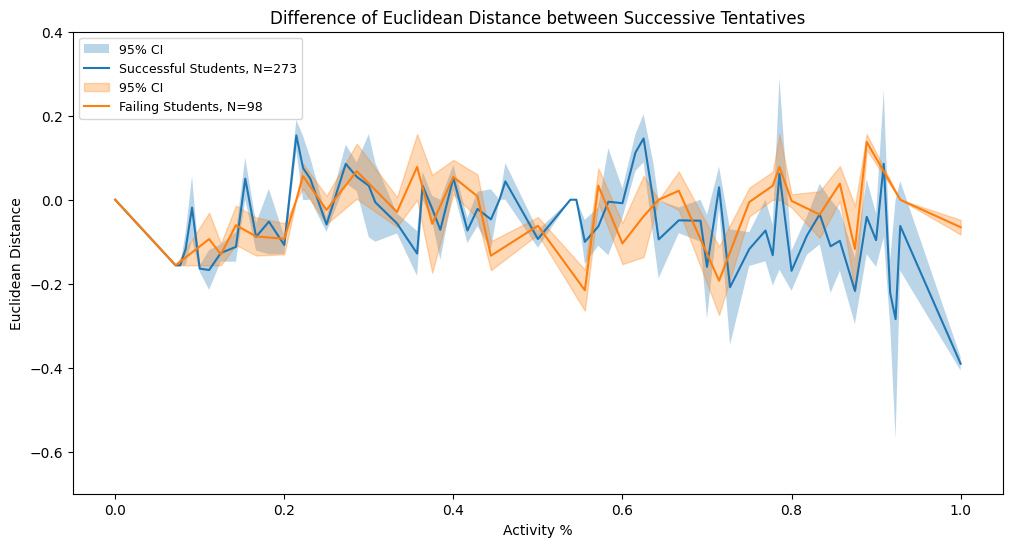

In [169]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# filter out the students with more than 10 tentatives
#data_success_deltas_filtered = data_success_deltas[data_success_deltas['nb_tentative'] <= 10]
#data_failing_deltas_filtered = data_failing_deltas[data_failing_deltas['nb_tentative'] <= 10]

grouped_success = data_success_deltas.groupby("pct_activity").agg({"delta": ["mean", "sem"], "Student ID": "count"})
grouped_success.columns = ["change_mean", "change_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_success = grouped_success.dropna(subset=["change_mean", "change_sem"])

grouped_success['ci_value'] = grouped_success["change_sem"] * 1.96

grouped_fail = data_failing_deltas.groupby("pct_activity").agg({"delta": ["mean", "sem"], "Student ID": "count"})
grouped_fail.columns = ["change_mean", "change_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_fail = grouped_fail.dropna(subset=["change_mean", "change_sem"])

grouped_fail['ci_value'] = grouped_fail["change_sem"] * 1.96

nb_fail_student = len(data_failing_deltas['Student ID'].unique())
nb_success_student = len(data_success_deltas['Student ID'].unique())

# Plot change in Euclidean distance for successful students
ax.fill_between(grouped_success.index, grouped_success['change_mean'] - grouped_success['change_sem'], grouped_success["change_mean"] + grouped_success['change_sem'], alpha=0.3, label="95% CI")
ax.plot(grouped_success.index, grouped_success['change_mean'], linestyle='-', label=f'Successful Students, N={nb_success_student}')

ax.fill_between(grouped_fail.index, grouped_fail['change_mean'] - grouped_fail['change_sem'], grouped_fail["change_mean"] + grouped_fail['change_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(grouped_fail.index, grouped_fail['change_mean'], color= '#ff7f0e', linestyle='-', label=f"Failing Students, N={nb_fail_student}")

# Set labels and title
ax.set_xlabel('Activity %')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Difference of Euclidean Distance between Successive Tentatives')
ax.legend(loc='upper left', fontsize=9)
plt.ylim(-0.7, 0.4)
plt.savefig(f'{folder}/difference_successive_tentatives.png')
plt.show()

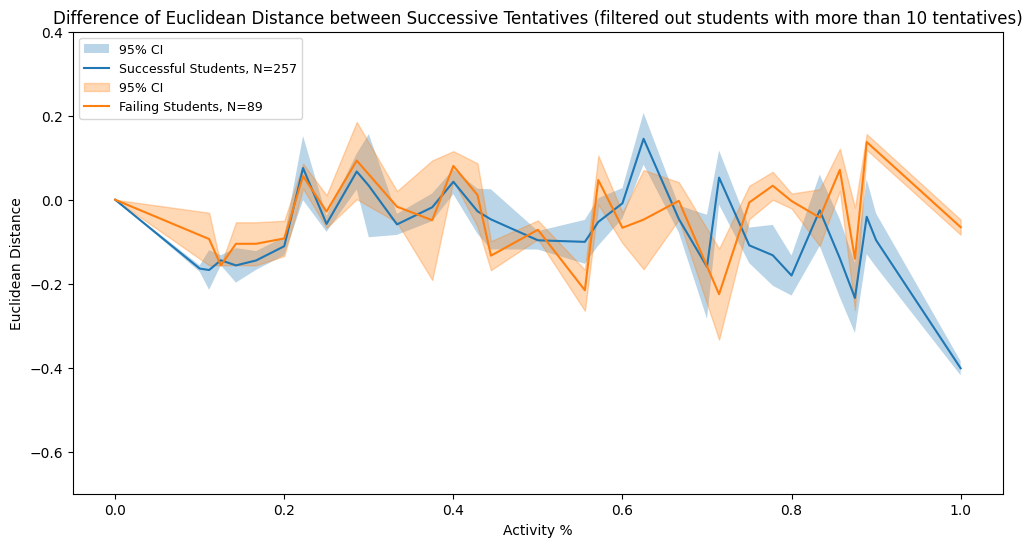

In [170]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# filter out the students with more than 10 tentatives
data_success_deltas_filtered = data_success_deltas[data_success_deltas['nb_tentative'] <= 10]
data_failing_deltas_filtered = data_failing_deltas[data_failing_deltas['nb_tentative'] <= 10]

grouped_success = data_success_deltas_filtered.groupby("pct_activity").agg({"delta": ["mean", "sem"], "Student ID": "count"})
grouped_success.columns = ["change_mean", "change_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_success = grouped_success.dropna(subset=["change_mean", "change_sem"])

grouped_success['ci_value'] = grouped_success["change_sem"] * 1.96

grouped_fail = data_failing_deltas_filtered.groupby("pct_activity").agg({"delta": ["mean", "sem"], "Student ID": "count"})
grouped_fail.columns = ["change_mean", "change_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_fail = grouped_fail.dropna(subset=["change_mean", "change_sem"])

grouped_fail['ci_value'] = grouped_fail["change_sem"] * 1.96

nb_fail_student = len(data_failing_deltas_filtered['Student ID'].unique())
nb_success_student = len(data_success_deltas_filtered['Student ID'].unique())

# Plot change in Euclidean distance for successful students
ax.fill_between(grouped_success.index, grouped_success['change_mean'] - grouped_success['change_sem'], grouped_success["change_mean"] + grouped_success['change_sem'], alpha=0.3, label="95% CI")
ax.plot(grouped_success.index, grouped_success['change_mean'], linestyle='-', label=f'Successful Students, N={nb_success_student}')

ax.fill_between(grouped_fail.index, grouped_fail['change_mean'] - grouped_fail['change_sem'], grouped_fail["change_mean"] + grouped_fail['change_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(grouped_fail.index, grouped_fail['change_mean'], color= '#ff7f0e', linestyle='-', label=f"Failing Students, N={nb_fail_student}")

# Set labels and title
ax.set_xlabel('Activity %')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Difference of Euclidean Distance between Successive Tentatives (filtered out students with more than 10 tentatives)')
ax.legend(loc='upper left', fontsize=9)

plt.ylim(-0.7, 0.4)
plt.savefig(f'{folder}/difference_successive_tentatives_filtered_outliers.png')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

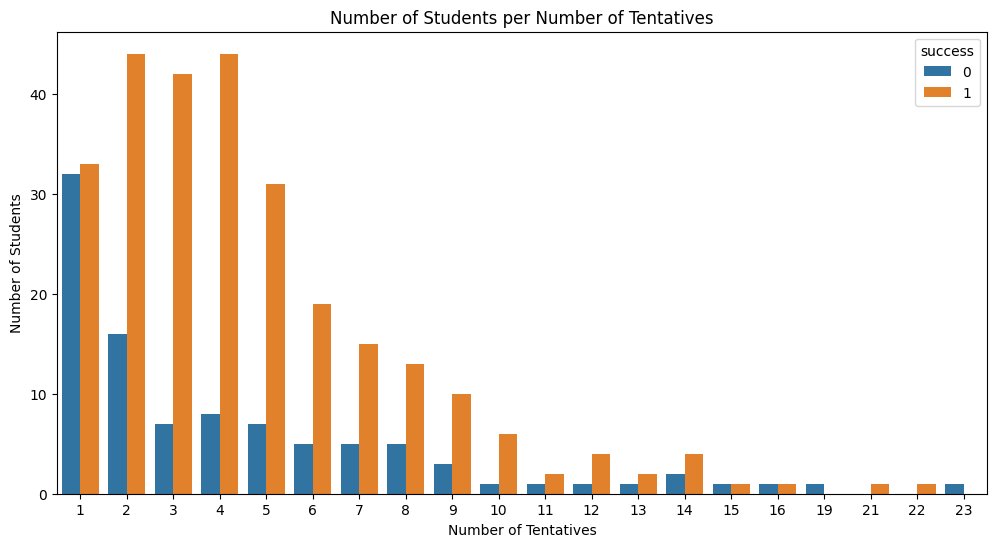

In [149]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives.png')
plt.show()

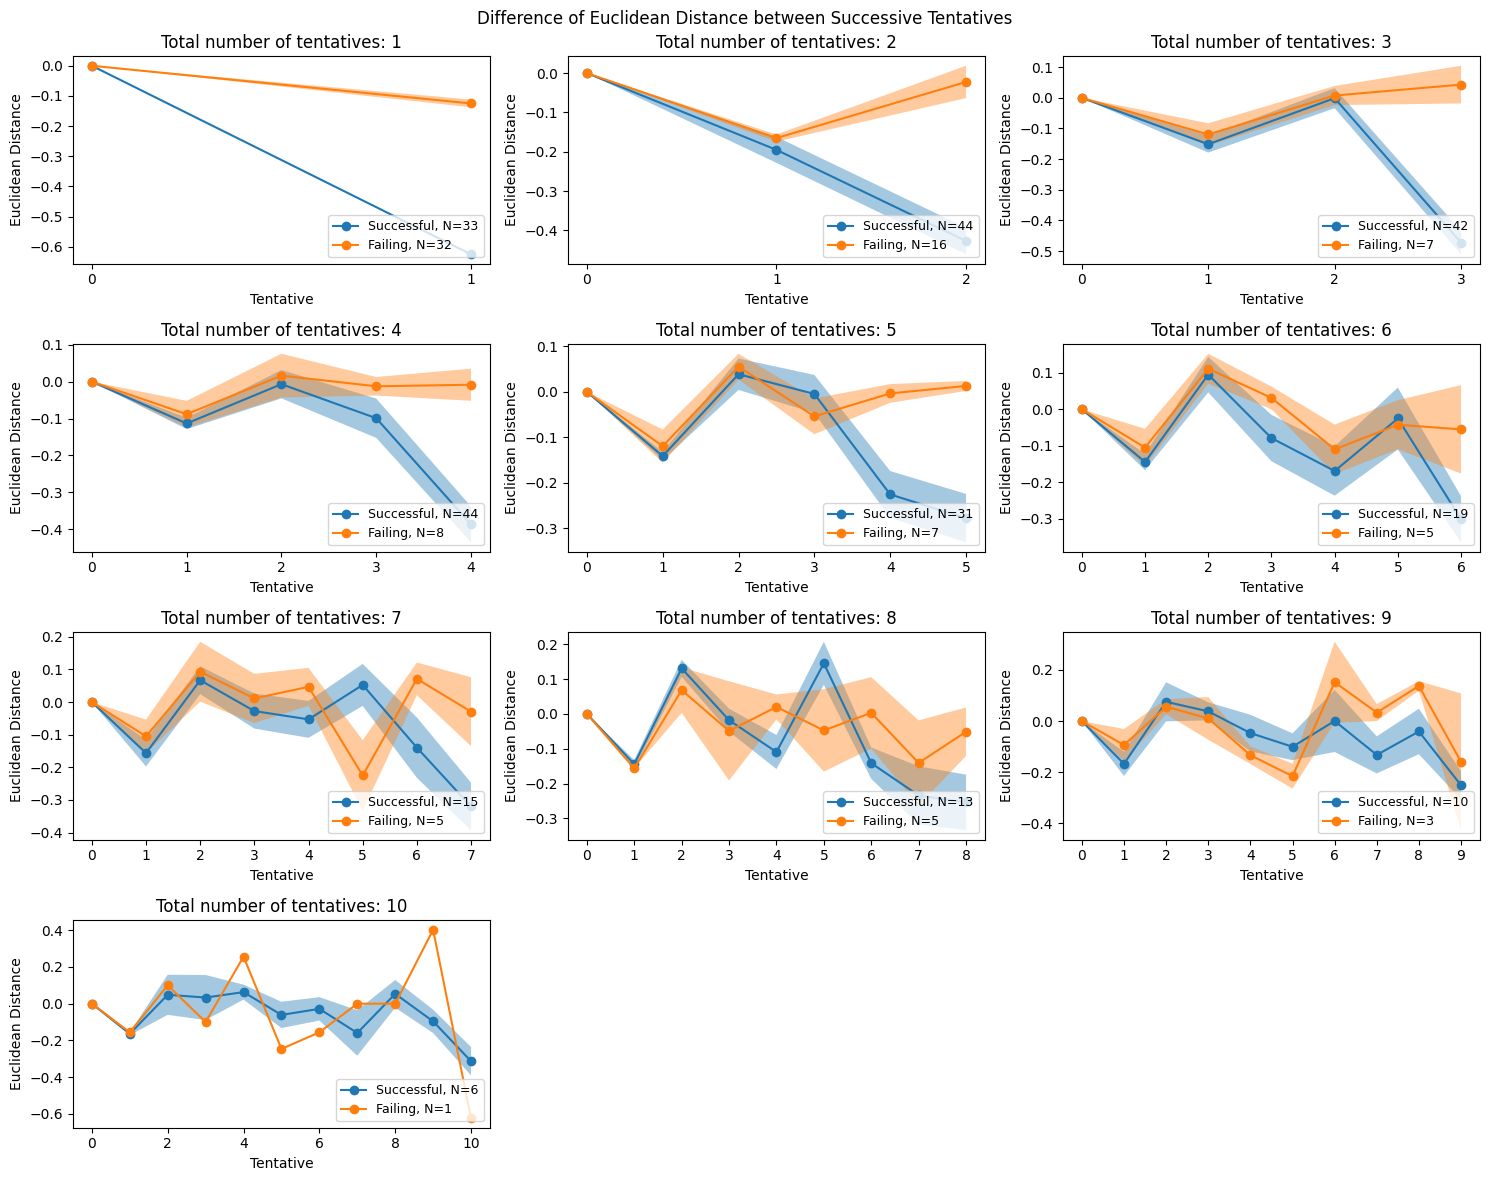

In [150]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success_deltas[data_success_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"delta": ["mean", "sem", "count"]})
        grouped_success.columns = ["delta_mean", "delta_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['delta_sem'].fillna(0, inplace=True)

        grouped_fail = data_failing_deltas[data_failing_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"delta": ["mean", "sem", "count"]})
        grouped_fail.columns = ["delta_mean", "delta_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['delta_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['delta_mean'] - grouped_success['delta_sem'], grouped_success["delta_mean"] + grouped_success['delta_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['delta_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['delta_mean'] - grouped_fail['delta_sem'], grouped_fail["delta_mean"] + grouped_fail['delta_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['delta_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        
        ax.set_title(f"Total number of tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean Distance")
        ax.legend(loc='lower right', fontsize=9)  # Move legend to upper right corner
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Difference of Euclidean Distance between Successive Tentatives')
plt.tight_layout()
plt.ylim(-1, 1)
plt.savefig(f'{folder}/euclidean_dist_diff_multi.png')
plt.show()


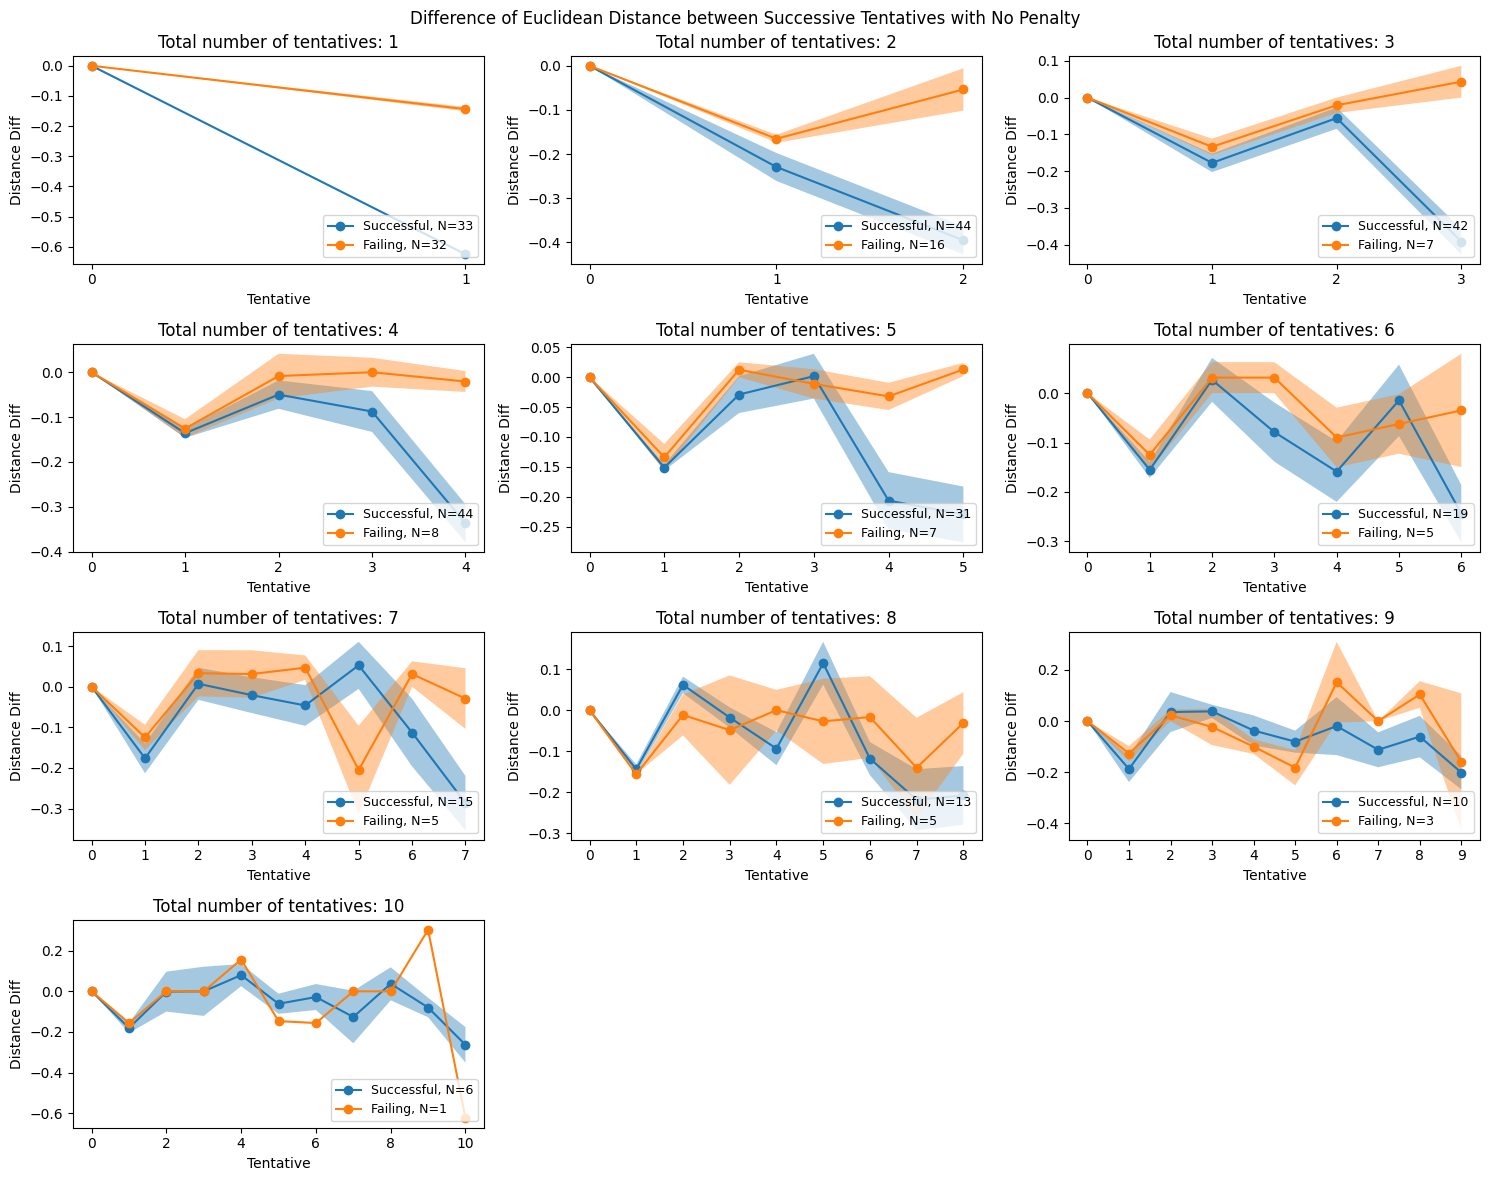

In [151]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
#tot_tentatives = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
#success_set = set(data_success_deltas['nb_tentative'])
#failing_set = set(data_failing_deltas['nb_tentative'])

tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success_deltas[data_success_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"delta_no_penalty": ["mean", "sem", "count"]})
        grouped_success.columns = ["delta_no_penalty_mean", "delta_no_penalty_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['delta_no_penalty_sem'].fillna(0, inplace=True)

        grouped_fail = data_failing_deltas[data_failing_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"delta_no_penalty": ["mean", "sem", "count"]})
        grouped_fail.columns = ["delta_no_penalty_mean", "delta_no_penalty_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['delta_no_penalty_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['delta_no_penalty_mean'] - grouped_success['delta_no_penalty_sem'], grouped_success["delta_no_penalty_mean"] + grouped_success['delta_no_penalty_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['delta_no_penalty_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['delta_no_penalty_mean'] - grouped_fail['delta_no_penalty_sem'], grouped_fail["delta_no_penalty_mean"] + grouped_fail['delta_no_penalty_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['delta_no_penalty_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        
        ax.set_title(f"Total number of tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Distance Diff")
        ax.legend(loc='lower right', fontsize=9)  # Move legend to upper right corner
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.ylim(-1, 1)
plt.suptitle('Difference of Euclidean Distance between Successive Tentatives with No Penalty')
plt.tight_layout()
plt.savefig(f'{folder}/euclidean_distance_diff_no_penalty_multi.png')
plt.show()

## Evalutation of the difference between successive runs 

### Descriptive analysis 

In [152]:
data_success_deltas.describe()

,nb_tentative,index,delta,delta_no_penalty,error,pct_activity
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,6.677419,3.338710,-0.108691,-0.109013,0.349032,0.500000
std,4.378089,3.349762,0.253130,0.226081,0.476818,0.350846
min,1.000000,0.000000,-0.724695,-0.624695,0.000000,0.000000
25%,4.000000,1.000000,-0.156174,-0.156174,0.000000,0.200000
50%,6.000000,2.000000,0.000000,0.000000,0.000000,0.500000
75%,9.000000,5.000000,0.000000,0.000000,1.000000,0.800000
max,22.000000,22.000000,0.724695,0.624695,1.000000,1.000000


In [153]:
data_failing_deltas.describe()

,nb_tentative,index,delta,delta_no_penalty,error,pct_activity
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,7.897921,3.948960,-0.027723,-0.036041,0.370510,0.500000
std,5.882126,4.249693,0.136478,0.123025,0.483399,0.360388
min,1.000000,0.000000,-0.624695,-0.624695,0.000000,0.000000
25%,3.000000,1.000000,-0.143502,-0.146561,0.000000,0.166667
50%,7.000000,3.000000,0.000000,0.000000,0.000000,0.500000
75%,12.000000,6.000000,0.000000,0.000000,1.000000,0.833333
max,23.000000,23.000000,0.468521,0.468521,1.000000,1.000000


## Overall analysis 

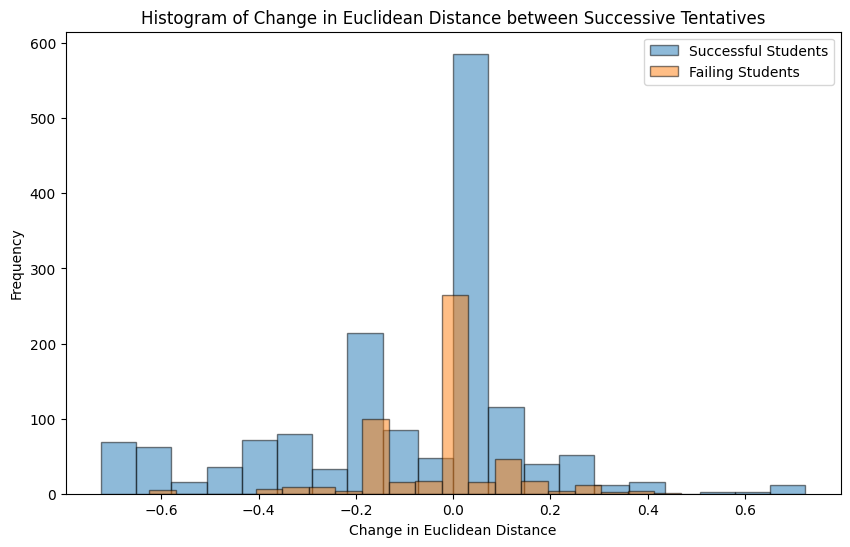

In [154]:
plt.figure(figsize=(10, 6))
plt.hist(data_success_deltas['delta'], bins=20, alpha=0.5, label="Successful Students", edgecolor='black')
plt.hist(data_failing_deltas['delta'], bins=20, alpha=0.5, label='Failing Students', edgecolor='black')

# Set labels and title
plt.xlabel('Change in Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Change in Euclidean Distance between Successive Tentatives')
plt.legend()
plt.show()

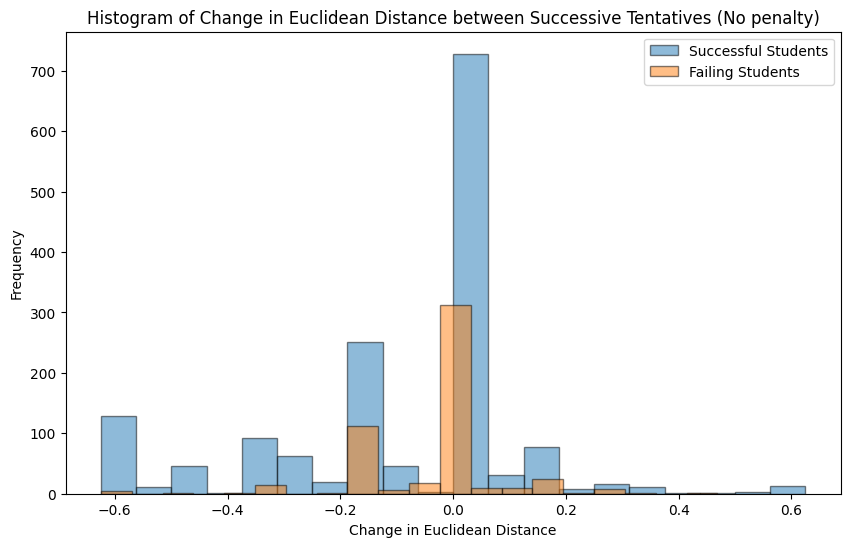

In [155]:
plt.figure(figsize=(10, 6))
plt.hist(data_success_deltas['delta_no_penalty'], bins=20, alpha=0.5, label="Successful Students", edgecolor='black')
plt.hist(data_failing_deltas['delta_no_penalty'], bins=20, alpha=0.5, label='Failing Students', edgecolor='black')

# Set labels and title
plt.xlabel('Change in Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Change in Euclidean Distance between Successive Tentatives (No penalty)')
plt.legend()
plt.show()

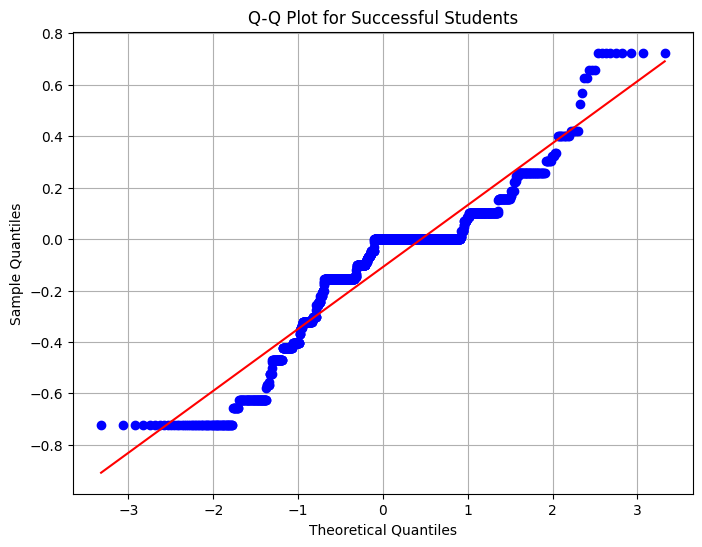

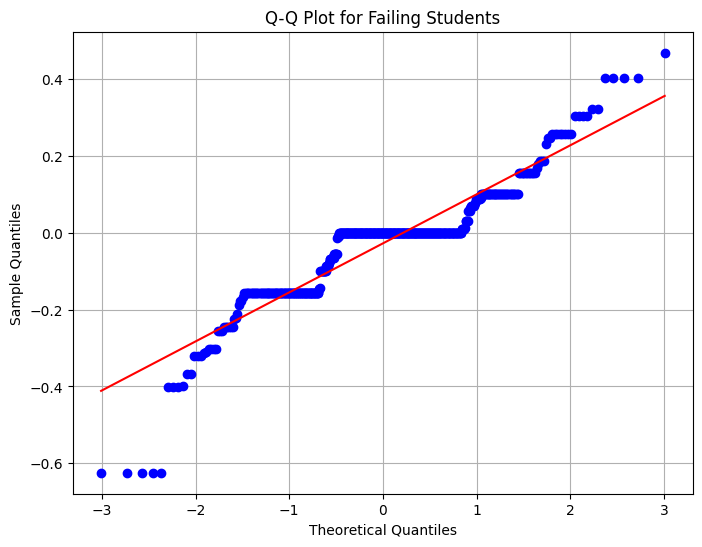

In [156]:
# Create Q-Q plot for successful students
plt.figure(figsize=(8, 6))
stats.probplot(data_success_deltas['delta'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Successful Students')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

# Create Q-Q plot for failing students
plt.figure(figsize=(8, 6))
stats.probplot(data_failing_deltas['delta'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Failing Students')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Data for the difference of euclidean distance between successive runs is normally distributed 

In [157]:
t_statistic, p_value = ttest_ind(data_success_deltas['delta'], data_failing_deltas['delta'])

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The change in Euclidean distance between successful and failing students is significant (p < 0.05)")
else:
    print("There is no significant difference in the change in Euclidean distance between successful and failing students (p >= 0.05)")


The change in Euclidean distance between successful and failing students is significant (p < 0.05)


### Let's observe if some variables are correlated 

In [158]:
relevant_columns = ['nb_tentative', 'index', 'delta', 'pct_activity']
relevant_data_success = data_success_deltas[relevant_columns]

correlation_matrix_success = relevant_data_success.corr()

print("Correlation Matrix:")
print(correlation_matrix_success)

Correlation Matrix:
              nb_tentative     index     delta  pct_activity
nb_tentative  1.000000e+00  0.653493  0.196834 -2.963936e-16
index         6.534926e-01  1.000000 -0.050302  6.156867e-01
delta         1.968341e-01 -0.050302  1.000000 -4.043283e-01
pct_activity -2.963936e-16  0.615687 -0.404328  1.000000e+00


In [159]:
relevant_data_failing = data_failing_deltas[relevant_columns]

# Calculate the correlation matrix
correlation_matrix_failing = relevant_data_failing.corr()

print("Correlation Matrix:")
print(correlation_matrix_failing)

#plt.figure(figsize=(8, 6))
#sns.heatmap(correlation_matrix_failing, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
#plt.title('Correlation Matrix')
#plt.show()

Correlation Matrix:
              nb_tentative     index     delta  pct_activity
nb_tentative  1.000000e+00  0.692065  0.102120 -5.753068e-18
index         6.920648e-01  1.000000  0.058837  5.395807e-01
delta         1.021200e-01  0.058837  1.000000 -7.786538e-02
pct_activity -5.753068e-18  0.539581 -0.077865  1.000000e+00


No results found: no undiscovered correlation 
* Correlation between index and number of tentatives which is obvious 
* Correlation between pct_activity and index, which is also obvious 

Next step: 
* Analyze the high differences by looking thoroughtly at the students concerned

Different type of errors: 
* move1 : cannot move, claw hit a wall 
* move 2 : collision, objects are stacked to high
* pickup1 : cannot pick up, claw is already holding an object 
* pickup2 : cannot place, claw is not holding any objet 

Should we differentiate the errors by giving a different penalty ? 

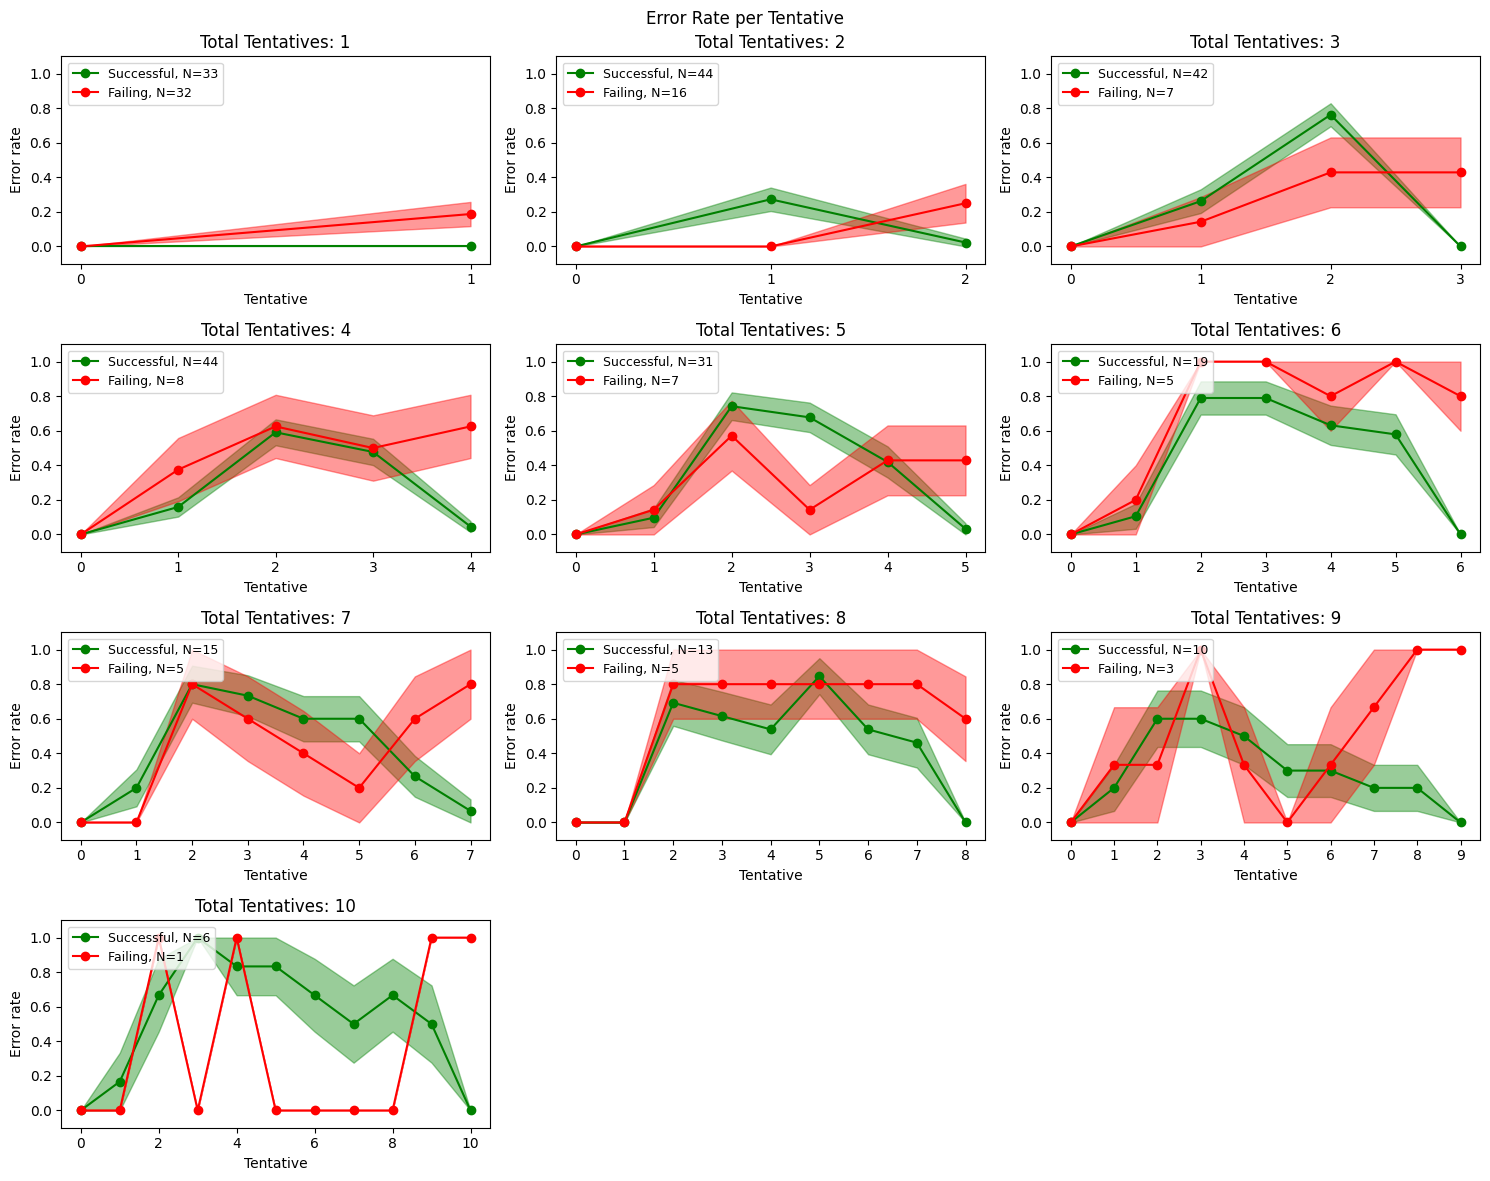

In [160]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success_deltas[data_success_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_success.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['error_sem'].fillna(0, inplace=True)

        grouped_fail = data_failing_deltas[data_failing_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_fail.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['error_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['error_mean'] - grouped_success['error_sem'], grouped_success["error_mean"] + grouped_success['error_sem'], alpha=0.4, color="green")
        ax.plot(grouped_success.index, grouped_success['error_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}", color="green")
        
        ax.fill_between(grouped_fail.index, grouped_fail['error_mean'] - grouped_fail['error_sem'], grouped_fail["error_mean"] + grouped_fail['error_sem'], alpha=0.4, color="red")
        ax.plot(grouped_fail.index, grouped_fail['error_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}", color="red")
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_multi.png')

plt.show()

What is the euclidean distance of a missing elements, but the other is placed correctly ? 

## Analysis of some students behaviors 

Interesting is to observe the students with a number of tentative 3, 6 and 7. 



In [161]:
def print_world(worlds):
    
    for world in worlds: 
        if (is_error(world)): 
            print("With error")
            print(preprocess(world))
        else:
            print("Without error")
            print(preprocess(world))

In [162]:
# construct a list of WorldSpace for each students, in order of increasing index
def construct_dict_list_worlds(df, nb_tentative):
    students = df[df['nb_tentative'] == nb_tentative]['Student ID'].unique()
    worlds = {}
    for student in students:
        student_worlds = df[(df['Student ID'] == student) & (df['nb_tentative'] == nb_tentative)]['WorldSpace'].values
        worlds[student] = student_worlds
    
    return worlds

def construct_list_worlds(df, student, nb_tentative):
    student_worlds = df[(df['Student ID'] == student) & (df['nb_tentative'] == nb_tentative)]['WorldSpace'].values
    student_worlds = student_worlds.tolist()
    
    return student_worlds